In [1]:
import os
import numpy as np
import soundfile as sf
import gpuRIR
from scipy.signal import convolve
import random
import librosa
from pathlib import Path

In [2]:
fs = 16000  # Target sample rate (change to 8000 if you want 8kHz)
input_sr = 32000  # Your WSJ files are at 32kHz
n_mics = 8
array_radius = 0.08  # 8 cm circular array
output_dir = "WSJ0_8ch_noisy_reverb"
wsj_clean_dir = "/home/ness/FuseMachines/audio/speech_seperation_pytorch/wsj0_32kHz_fixed"
noise_dir = "/home/ness/FuseMachines/audio/speech_seperation_pytorch/noise"

# Create output folders
os.makedirs(f"{output_dir}/mix", exist_ok=True)
os.makedirs(f"{output_dir}/s1", exist_ok=True)
os.makedirs(f"{output_dir}/s2", exist_ok=True)  # ← Added s2 directory

In [3]:
# Load noise files once
print("Loading noise files...")
noises = []
for noise_file in Path(noise_dir).rglob("*.wav"):
    noise, sr_noise = sf.read(noise_file)
    noise = librosa.resample(np.squeeze(noise).astype(np.float32), 
                            orig_sr=sr_noise, target_sr=fs)
    noises.append(noise)
print(f"Loaded {len(noises)} noise files")

def create_mic_array(n_mics=8, radius=0.08):
    """Create circular microphone array positions"""
    angles = np.linspace(0, 2*np.pi, n_mics, endpoint=False)
    pos = np.stack([radius * np.cos(angles),
                    radius * np.sin(angles),
                    np.zeros(n_mics)], axis=1)
    return pos

mic_positions_relative = create_mic_array(n_mics=n_mics, radius=array_radius)

Loading noise files...
Loaded 87 noise files


In [4]:
def random_room():
    """Generate random room dimensions and T60"""
    room_sz = [
        random.uniform(5.0, 12.0),   # x
        random.uniform(4.5, 10.0),   # y
        random.uniform(2.7, 4.0)     # z
    ]
    T60 = random.uniform(0.20, 0.85)  # 200–850 ms
    return room_sz, T60

In [5]:
# Try to import T60_to_beta, if not available, define it manually
try:
    from gpuRIR import T60_to_beta
except ImportError:
    def T60_to_beta(T60, room_sz):
        """Convert T60 reverberation time to reflection coefficients"""
        # Sabine's formula: T60 = 0.161 * V / A
        # where V is volume, A is absorption area
        # beta = sqrt(1 - alpha) where alpha is absorption coefficient
        V = np.prod(room_sz)  # Room volume
        S = 2 * (room_sz[0]*room_sz[1] + room_sz[0]*room_sz[2] + room_sz[1]*room_sz[2])  # Surface area
        
        if T60 == 0:
            return [0.0] * 6  # Anechoic
        
        alpha = 0.161 * V / (S * T60)  # Absorption coefficient
        alpha = np.clip(alpha, 0, 0.99)  # Ensure valid range
        beta_val = np.sqrt(1 - alpha)
        
        return [beta_val] * 6  # Same reflection for all 6 walls

In [6]:
def simulate_multi_channel_RIR(room_sz, T60, src_pos, mic_pos, fs=16000):
    """Simulate Room Impulse Response using gpuRIR"""
    beta = T60_to_beta(T60, room_sz)
    
    # Ensure src_pos is 2D array: (1, 3) for single source
    if isinstance(src_pos, list):
        src_pos = np.array(src_pos)
    if src_pos.ndim == 1:
        src_pos = src_pos.reshape(1, -1)
    
    RIRs_obj = gpuRIR.simulateRIR(
        room_sz=room_sz,
        beta=beta,
        pos_src=src_pos,
        pos_rcv=mic_pos,
        nb_img=[18, 18, 18],
        Tmax=1.6,
        fs=fs
    )
    # Convert object array to proper float32 array
    RIRs = np.stack(RIRs_obj).astype(np.float32)
    if RIRs.ndim == 3 and RIRs.shape[0] == 1:
        RIRs = RIRs[0]
    return RIRs  # shape: (n_mics, samples)

In [7]:
def apply_reverb(signal, RIRs):
    """Apply reverberation to a mono signal for all microphones"""
    from scipy.signal import fftconvolve
    
    # Force clean 1D float32 signal
    sig = np.squeeze(signal).astype(np.float32).ravel()
    
    # Force clean (n_mics, samples) RIRs
    rirs = np.atleast_2d(RIRs).astype(np.float32)
    n_mics = rirs.shape[0]
    
    # Convolve each microphone's RIR with the signal
    output = []
    for m in range(n_mics):
        rir_1d = np.squeeze(rirs[m]).ravel().astype(np.float32)
        reverb_sig = fftconvolve(sig, rir_1d, mode='full')
        output.append(reverb_sig)
    
    return np.array(output, dtype=np.float32)  # shape: (n_mics, T_reverb)


In [8]:
def create_one_mixture(path1, path2):
    """Create one reverberant, noisy mixture with two speakers"""
    
    # Load clean speech at 32kHz
    s1_32k, sr1 = sf.read(path1)
    s2_32k, sr2 = sf.read(path2)
    
    # Resample to target fs
    s1 = librosa.resample(np.squeeze(s1_32k).astype(np.float32), 
                         orig_sr=sr1, target_sr=fs)
    s2 = librosa.resample(np.squeeze(s2_32k).astype(np.float32), 
                         orig_sr=sr2, target_sr=fs)
    
    # Match lengths
    min_len = min(len(s1), len(s2))
    s1, s2 = s1[:min_len], s2[:min_len]
    
    # Random room & acoustics
    room_sz, T60 = random_room()
    room_center = np.array(room_sz) / 2
    
    # Place TWO DIFFERENT speaker positions
    # Speaker 1: offset from center
    angle1 = random.uniform(0, 2*np.pi)
    distance1 = random.uniform(0.5, min(room_sz[0], room_sz[1])/2 - 0.5)
    src1_pos = room_center.copy()
    src1_pos[0] += distance1 * np.cos(angle1)
    src1_pos[1] += distance1 * np.sin(angle1)
    src1_pos[2] = random.uniform(1.0, room_sz[2] - 0.5)
    
    # Speaker 2: different position (at least 60 degrees apart)
    angle2 = angle1 + random.uniform(np.pi/3, 2*np.pi - np.pi/3)
    distance2 = random.uniform(0.5, min(room_sz[0], room_sz[1])/2 - 0.5)
    src2_pos = room_center.copy()
    src2_pos[0] += distance2 * np.cos(angle2)
    src2_pos[1] += distance2 * np.sin(angle2)
    src2_pos[2] = random.uniform(1.0, room_sz[2] - 0.5)
    
    # Mic array centered at fixed height
    mic_pos = mic_positions_relative + room_center
    mic_pos[:, 2] = 1.5
    
    # Simulate SEPARATE RIRs for each speaker
    RIRs_s1 = simulate_multi_channel_RIR(room_sz, T60, src1_pos, mic_pos, fs)
    RIRs_s2 = simulate_multi_channel_RIR(room_sz, T60, src2_pos, mic_pos, fs)
    
    # Apply reverb to EACH speaker separately
    s1_reverb = apply_reverb(s1, RIRs_s1)  # (n_mics, T_reverb1)
    s2_reverb = apply_reverb(s2, RIRs_s2)  # (n_mics, T_reverb2)
    
    # Match lengths after reverb (take minimum)
    min_reverb_len = min(s1_reverb.shape[1], s2_reverb.shape[1])
    s1_reverb = s1_reverb[:, :min_reverb_len]
    s2_reverb = s2_reverb[:, :min_reverb_len]
    
    # NOW mix the reverberated signals
    multi_ch = s1_reverb + s2_reverb  # (n_mics, T)
    T_actual = multi_ch.shape[1]
    
    # Add random noise at random SNR
    noise = random.choice(noises)
    
    # Ensure noise segment matches length
    if len(noise) < T_actual:
        repeats = int(np.ceil(T_actual / len(noise)))
        noise = np.tile(noise, repeats)
    
    start = random.randint(0, max(0, len(noise) - T_actual))
    noise_seg = noise[start:start + T_actual].astype(np.float32)
    
    # Calculate SNR and scale
    SNR = random.uniform(0, 25)
    noise_power = np.mean(noise_seg**2)
    signal_power = np.mean(multi_ch**2, axis=1, keepdims=True)
    scale = np.sqrt(signal_power / (noise_power * 10**(SNR/10) + 1e-9))
    
    # Add noise (broadcast across all channels)
    multi_ch = multi_ch + scale * noise_seg[np.newaxis, :]
    
    # Normalize to -25 dBFS
    rms = np.sqrt(np.mean(multi_ch**2, axis=1, keepdims=True)) + 1e-9
    multi_ch = multi_ch * (10**(-25/20) / rms)
    
    # For reference signals, take first microphone channel
    s1_ref = s1_reverb[0, :]  # First mic, with reverb
    s2_ref = s2_reverb[0, :]  # First mic, with reverb
    
    # Normalize reference signals similarly
    s1_ref = s1_ref * (10**(-25/20) / (np.sqrt(np.mean(s1_ref**2)) + 1e-9))
    s2_ref = s2_ref * (10**(-25/20) / (np.sqrt(np.mean(s2_ref**2)) + 1e-9))
    
    return multi_ch, s1_ref, s2_ref, room_sz, T60, SNR

In [9]:
# Main generation loop
clean_files = list(Path(wsj_clean_dir).rglob("*.wav"))
print(f"\nFound {len(clean_files)} clean WSJ files. Starting generation...")
print(f"Output directory: {output_dir}")
print(f"Generating mix, s1, and s2 at {fs} Hz\n")

for i in range(23000):
    spk1 = random.choice(clean_files)
    spk2 = random.choice(clean_files)
    
    # Ensure different speakers
    while spk2 == spk1:
        spk2 = random.choice(clean_files)
    
    try:
        mix_8ch, s1_reverb, s2_reverb, room, t60, snr = create_one_mixture(str(spk1), str(spk2))
        
        split = "tr" if i < 20000 else "cv"
        uid = f"{split}{i:06d}"
        
        # Save all three
        sf.write(f"{output_dir}/mix/{uid}_mix.wav", mix_8ch.T, fs)      # (T, 8) channels
        sf.write(f"{output_dir}/s1/{uid}_s1.wav", s1_reverb, fs)        # mono with reverb
        sf.write(f"{output_dir}/s2/{uid}_s2.wav", s2_reverb, fs)        # mono with reverb
        
        if i % 500 == 0:
            print(f"Generated {i+1}/23000 → T60={t60:.2f}s  SNR={snr:.1f}dB  Room={[f'{x:.1f}' for x in room]}")
    
    except Exception as e:
        print(f"Error processing mixture {i}: {e}")
        continue

print(f"\n✅ DONE! Dataset ready at {fs} Hz with mix, s1, and s2.")
print(f"Dataset structure:")
print(f"  {output_dir}/mix/  - 8-channel reverberant noisy mixtures")
print(f"  {output_dir}/s1/   - Speaker 1 (reverberant, first mic)")
print(f"  {output_dir}/s2/   - Speaker 2 (reverberant, first mic)")



Found 18671 clean WSJ files. Starting generation...
Output directory: WSJ0_8ch_noisy_reverb
Generating mix, s1, and s2 at 16000 Hz

Generated 1/23000 → T60=0.79s  SNR=23.8dB  Room=['6.4', '8.5', '3.2']
Generated 501/23000 → T60=0.56s  SNR=20.2dB  Room=['5.1', '9.3', '3.5']
Generated 1001/23000 → T60=0.31s  SNR=13.8dB  Room=['9.9', '6.8', '2.8']
Generated 1501/23000 → T60=0.44s  SNR=22.0dB  Room=['11.6', '6.5', '3.5']
Generated 2001/23000 → T60=0.62s  SNR=3.9dB  Room=['11.8', '8.4', '3.9']
Generated 2501/23000 → T60=0.38s  SNR=17.4dB  Room=['8.9', '6.2', '3.5']
Generated 3001/23000 → T60=0.39s  SNR=0.4dB  Room=['10.7', '8.8', '3.5']
Generated 3501/23000 → T60=0.52s  SNR=8.1dB  Room=['11.5', '5.6', '3.1']
Generated 4001/23000 → T60=0.22s  SNR=5.4dB  Room=['11.7', '7.2', '3.5']
Generated 4501/23000 → T60=0.61s  SNR=8.4dB  Room=['10.1', '9.2', '2.9']
Generated 5001/23000 → T60=0.76s  SNR=18.6dB  Room=['6.6', '5.7', '3.9']
Generated 5501/23000 → T60=0.23s  SNR=17.7dB  Room=['7.8', '7.3', '

In [10]:
# sound analysis

#spectogram of a raw audio

#spectogram of a mix noisy and reverb audio

#spectogram of a s1 noisy and reverb audio

In [11]:
# Extracting Short-Time Fourier transform
FRAME_SIZE = 2048 #2048 samples in 1 frame
HOP_LENGTH = 512 #hop 512 samples at a time.

import matplotlib.pyplot as plt

In [12]:
def get_spectogram(audio_file, fmin=0, fmax=2000):
    audio, sr = librosa.load(audio_file)
    S_scale = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    Y_scale = np.abs(S_scale)**2 #squared magnitude of short time fourier transform is the spectogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(Y_scale, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis= 'linear',
    fmin=0,
    fmax=4000)
    plt.ylim(fmin, fmax)
    plt.colorbar(format='%+2.0f dB')




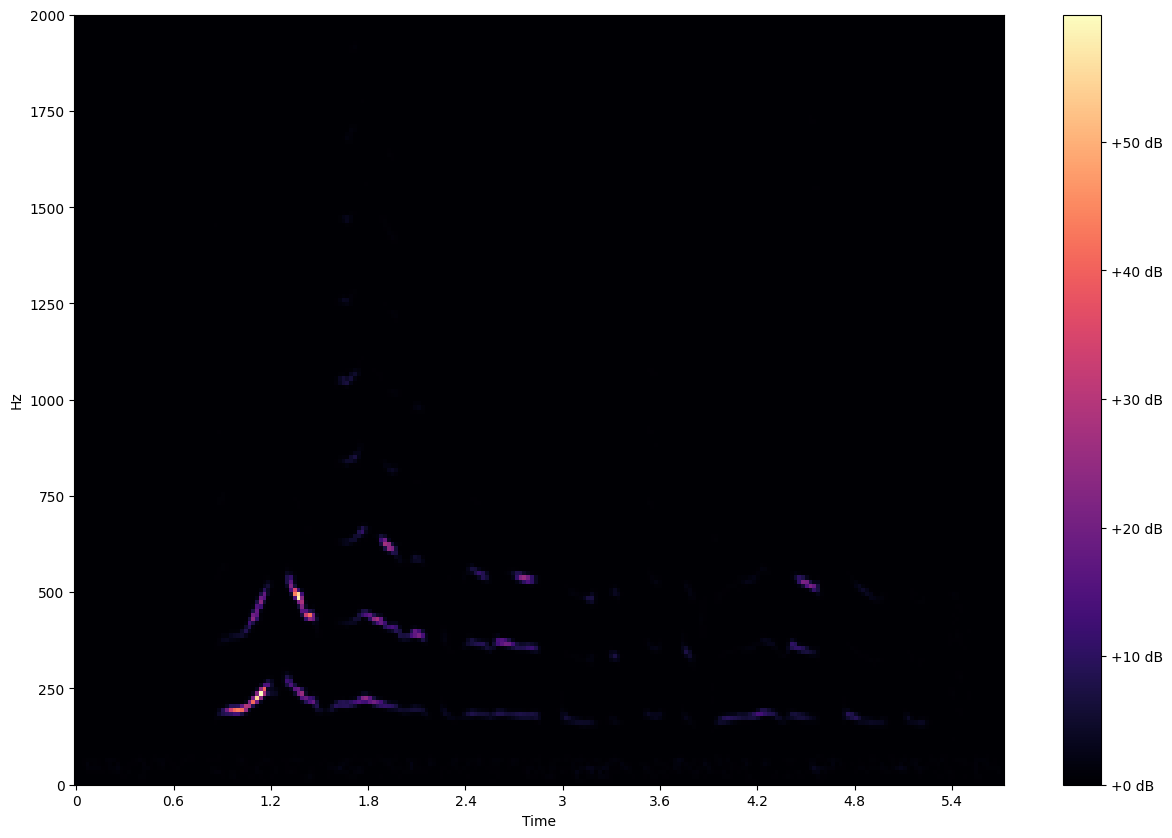

In [13]:
raw_audio_file = '/home/ness/FuseMachines/audio/speech_seperation_pytorch/wsj0_32kHz_fixed/si_tr_s/01a/01aa010a.wav'
mix_noisy_reverb_file = '/home/ness/FuseMachines/audio/speech_seperation_nbc/WSJ0_8ch_noisy_reverb/mix/cv020002_mix.wav'
s1_noisy_reverb_file = '/home/ness/FuseMachines/audio/speech_seperation_nbc/WSJ0_8ch_noisy_reverb/s1/cv020000_s1.wav'
get_spectogram(raw_audio_file)

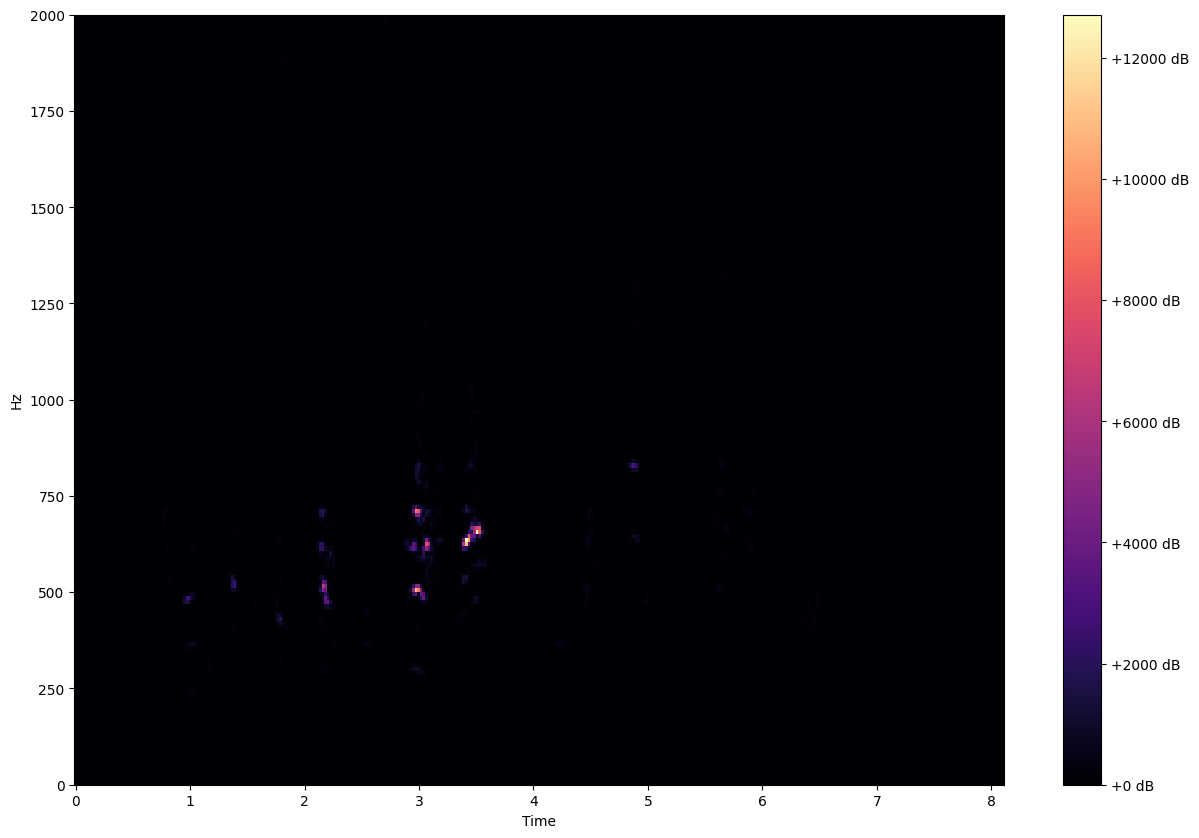

In [14]:
get_spectogram(s1_noisy_reverb_file)

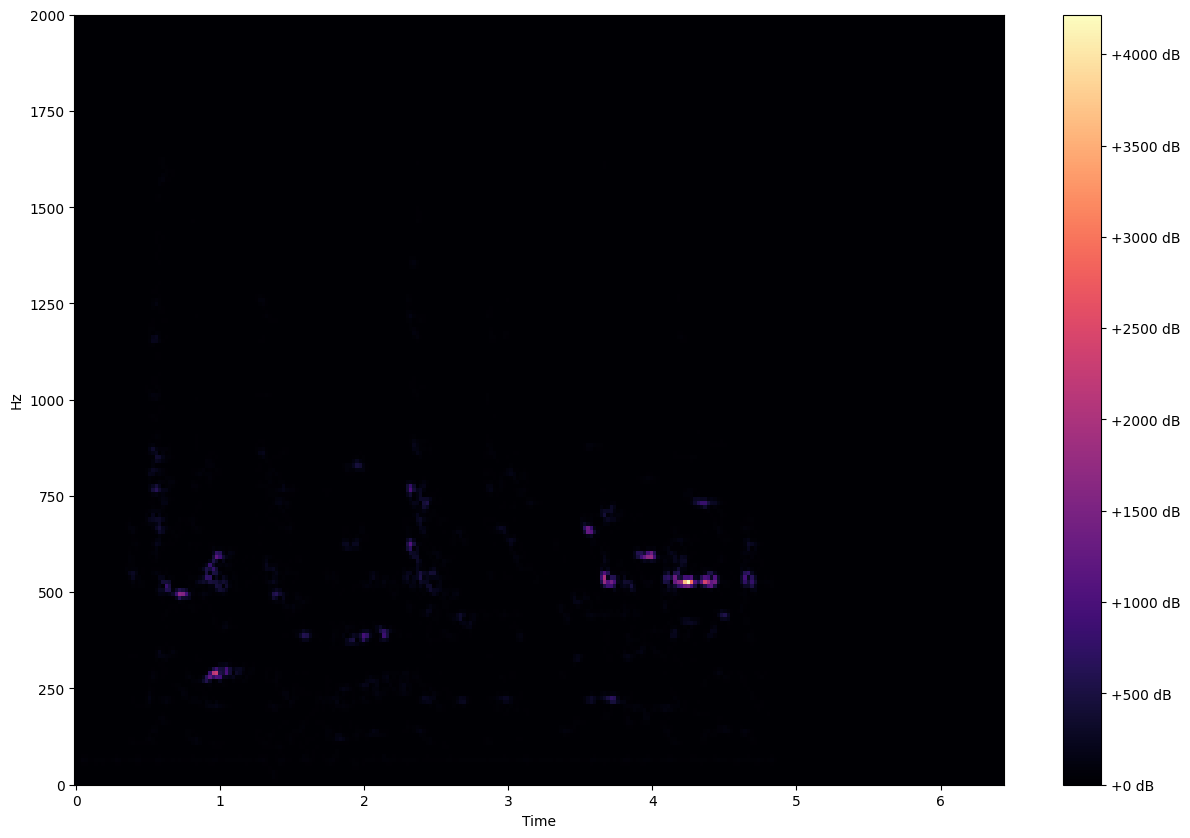

In [15]:
get_spectogram(mix_noisy_reverb_file)